In [ ]:
#@title **Loading data from gdrive to memory**
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Biomedicine
%cd dataset_bio_AI

# Copy rar file to temporaray drive (/content). It should take about 1 minute
!cp /content/drive/MyDrive/Biomedicine/dataset_bio_AI/TFR_xray_256_size.zip /content/
%cd /content/

# Unzip files in the temp drive. It should take about 3 minutes
#-o- switch does not overwrite existing files. -c- switch should avoid prompting -> should be faster.
!unzip TFR_xray_256_size.zip


## Directory definition

In [ ]:
dir = "/content/drive/MyDrive/Biomedicine/"
train_dir = "/content/TFRdataset/training.tfrecords"
test_dir = "/content/TFRdataset/test.tfrecords"
val_dir = "/content/TFRdataset/validation.tfrecords"

import libreries

In [ ]:
import tensorflow as tf
import cv2
import warnings
import logging
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from PIL import Image
import time
from datetime import datetime

plt.style.use('ggplot')


tfk = tf.keras
tfkl = tf.keras.layers


# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Warning: no GPU is running")

In [ ]:
#@title **Setting seed and/or suppressing warnings**
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
#@title **Utility function to create folders and callbacks for training**
def create_folders_and_callbacks(model_name, dir, patience=15):

  #exps_dir = os.path.join('trained_models')
  exps_dir = dir + 'trained_models'
  print(exps_dir)
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%m-%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  print(exp_dir)
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                                                     filepath=ckpt_dir + '/cp-{val_accuracy:.2f}-{epoch:02d}.ckpt', # Checkpoint is saved with validation accuracy in the filename
                                                     monitor='val_accuracy', 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=True, # True to save only the best epoch 
                                                     initial_value_threshold=0.85
                                                     ) # Model is saved only if val_accuracy > initial_value_threshold

  callbacks.append(ckpt_callback)


  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks, exp_dir

# COMPUTING WEIGHTS


computing weights for the weighted loss function. Less frequent are samples from a given category, the higher will be the penalty on missing the correct label.

In [ ]:
def count_samples(directory):
  count = 0
  for root_dir, cur_dir, files in os.walk(directory):
      count += len(files)
  return count

count_samples(train_dir)

In [ ]:
weights = {0: 0.5514705882352942, 1: 1.208968347010551, 2: 2.781523937963587}

# Gradcam

In [ ]:
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        preprocessing = Gray2VGGInput( name='gray_to_rgb_norm')
        rgb_img = preprocessing(img_array)
        last_conv_layer_output, preds = grad_model(rgb_img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tfk.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tfk.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tfk.utils.array_to_img(superimposed_img)

    return superimposed_img

# Evaluation functions


In [ ]:
def build_heatmap(model, validation_generator):
    """
    This method generates an heatmap used by seaborn to create a confusion matrix.
    :param model: model for which the method computes the confusion matrix.
    :param validation_generator: dataset object over which the model computes its predictions.
    :return pd.DataFrame object containing the confusion matrix.
    """
    y_predicted = model.predict(validation_generator)
    y_predicted = tf.argmax(y_predicted, axis=1)
    y_test_labels = np.concatenate([y for x, y in validation_generator], axis=0)
    y_test_labels = tf.argmax(y_test_labels, axis=1)
    confusion_matrix = tf.math.confusion_matrix(
        y_test_labels, 
        y_predicted,
        num_classes=3
    )
    c = []
    for item in confusion_matrix:
        c.append(np.around(item / np.sum(item), decimals=3))
    df_heatmap = pd.DataFrame(c)
    return df_heatmap


In [ ]:
def compute_report(model, test):
  """
  Compute recall, precision and f1-score for each class, for a model predicting
  on a given set.
  :param model: model to evaluate
  :param test: test set over which this method evaluate the input model.
  :return a pandas dataframe containing precision, recall and f1-score of the model.
  """

  # compute predictions
  y_pred = model.predict(test)
  y_pred = tf.argmax(y_pred, axis=1)

  # get true labels
  y_true = np.concatenate([y for x, y in test], axis=0)
  y_true = tf.argmax(y_true, axis=1)

  # return report  
  report = classification_report(y_true,
                                 y_pred,
                                 target_names=['n', 'p', 't'],
                                 output_dict=True)
  
  report = pd.DataFrame(report)
  report = report.drop(['accuracy',	'macro avg',	'weighted avg'], axis=1)
  return report

def plot_accuracy(history):
  x_axis = len(history.history["accuracy"])
  print(max(history.history["val_accuracy"]), max(history.history["accuracy"]))
  history.history.keys()
  plt.figure(figsize=(12, 6))
  plt.plot([i for i in range(x_axis)], history.history["accuracy"], label="train accuracy")
  plt.plot([i for i in range(x_axis)], history.history["val_accuracy"], label="validation accuracy")
  plt.legend()

  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.ylim([0, 1])
  plt.show()

## #Custom Evaluation function

In [ ]:
from sklearn import metrics


def find_nearest(array, value):
    """
    This function compute the index of the closest element for a given vale.
    :param array: numpy array where to search.
    :param value: value to search.
    :return integer representing the index of the closest element
    """
    idx = (np.abs(array - value)).argmin()
    return idx


def compute_Youden_idx(tpr, fpr):
    """
    Compute the closest point of the ROC curve to the point (0, 1).
    Return an integer representing the index of the closest point to (0, 1).
    """
    distances = np.sqrt((1 - tpr) ** 2 + (0 - fpr) ** 2)
    return np.argmin(distances)


def plot_roc_n_vs_t(true_y, predictions, t_sensitivity=0.5, n_sensitivity=0.5, maximize_AUC=False):
    """
    This function plot the OvO ROC cuve for tubercolosis and healthy class.
    :param true_y: array of one hot encoding for the true labels.
    :param predictions: array of predictions. Predictions must be distributions.
    :param t_sensitivity: threashold over which tubercolosis(when positive class) is considered True.
    :param n_sensitivity: threashold over which healthy(when positive class) is considered True.
    :param maximize_AUC: if True, plot the point closest to the point (0, 1) and compute the thesholds for those points.
    :return thresholds.
    """
    labels = tf.argmax(true_y, axis=-1).numpy()

    mask_n = labels == 0
    mask_t = labels == 2
    mask = np.logical_or(mask_n, mask_t)

    fpr_n, tpr_n, thresholds_n = metrics.roc_curve(mask_n[mask], predictions[mask, 0])
    fpr_t, tpr_t, thresholds_t = metrics.roc_curve(mask_t[mask], predictions[mask, 2])
    
    color_n = "#f72585"

    plt.figure(figsize=(7, 7))

    if maximize_AUC:
        idx_n = compute_Youden_idx(fpr=fpr_n, tpr=tpr_n)
    else:
        idx_n = find_nearest(thresholds_n, n_sensitivity)


    roc_auc_n = metrics.auc(fpr_n, tpr_n)
    plt.plot(
        fpr_n,
        tpr_n,
        label='Healthy as positive class',
        color=color_n
    )
    plt.plot(fpr_n[idx_n], tpr_n[idx_n] , marker="o", markersize=10, markeredgecolor=color_n, markerfacecolor=color_n)

    color_t = "#7209b7"

    if maximize_AUC:
        idx_t = compute_Youden_idx(fpr=fpr_t, tpr=tpr_t)
    else:
        idx_t = find_nearest(thresholds_t, t_sensitivity)

    roc_auc_t = metrics.auc(fpr_t, tpr_t)
    plt.plot(
        fpr_t,
        tpr_t, label='Tubercolosis as positive class',
        color=color_t
    )
    plt.plot(fpr_t[idx_t], tpr_t[idx_t] , marker="o", markersize=10, markeredgecolor=color_t, markerfacecolor=color_t)
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC curves")

    plt.legend()
    plt.show()
    return thresholds_n[idx_n], thresholds_t[idx_t]


In [ ]:
def compute_best_point(precision, recall):
    """
    Compute the closest point of the precision vs recall curve to the point (1, 1).
    Return an integer representing the index of the closest point to (1, 1).
    """
    distances = np.sqrt((1 - precision) ** 2 + (1 - recall) ** 2)
    return np.argmin(distances)


def plot_precision_recall_t(true_y, predictions):
    """
    This function plots the precision vs recall curve for the tubercolosis as positive class.
    :param true_y: array of one hot encoding for the true labels.
    :param predictions: array of predictions. Predictions must be distributions.
    :return best threshold (the one closest to the point with recall=precision=1).
    """
    labels = tf.argmax(true_y, axis=-1).numpy()

    mask_n = labels == 0
    mask_t = labels == 2
    mask = np.logical_or(mask_n, mask_t)

    precision, recall, thresholds_t = metrics.precision_recall_curve(mask_t[mask], predictions[mask, 2])
    
    color_t = "#7209b7"

    plt.figure(figsize=(7, 7))

    idx_t_m = compute_best_point(precision=precision, recall=recall)
    idx_t = find_nearest(thresholds_t, 0.5)

    plt.plot(
        recall,
        precision,
        label='Tubercoloss as positive class',
        color=color_t
    )
    plt.plot(recall[idx_t_m],
        precision[idx_t_m],
        marker="o",
        markersize=10,
        markeredgecolor=color_t,
        markerfacecolor=color_t,
        label=f'best threshold ({thresholds_t[idx_t_m]})'
    )
    plt.plot(recall[idx_t],
        precision[idx_t],
        marker="o",
        markersize=10,
        markeredgecolor="#f72585",
        markerfacecolor="#f72585",
        label=f'default threshold (0.5)'
    )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-vs-Recall curve")

    plt.legend()
    plt.show()
    return thresholds_t[idx_t_m]


In [ ]:
def build_heatmap_custom(true_y, predictions, threshold, policy=None):
    """
    Compute pd dataframe containing the confusion matrix.
    :param true_y: array of one hot encoding for the true labels.
    :param predictions: array of predictions. Predictions must be distributions.
    :param policy: function policy to compute the label. If none(default), tf.argmax() is used.
    :param threshold: parameter of policy
    :return a pandas dataframe containing the confusion matrix.
    """
    if policy is None:
        y_pred = tf.argmax(predictions, axis=-1)
    else:
        y_pred = policy(predictions, threshold)

    # get true labels
    y_true = tf.argmax(true_y, axis=1)
    confusion_matrix = tf.math.confusion_matrix(
        y_true, 
        y_pred,
        num_classes=3
    )
    c = []
    for item in confusion_matrix:
        c.append(np.around(item / np.sum(item), decimals=3))
    df_heatmap = pd.DataFrame(c)
    return df_heatmap


def compute_report_custom(true_y, predictions, threshold, policy=None):
    """
    Compute recall, precision and f1-score for each class, for a model predicting
    on a given set.
    :param true_y: array of one hot encoding for the true labels.
    :param predictions: array of predictions. Predictions must be distributions.
    :param threshold: parameter of policy
    :param policy: function policy to compute the label. If none(default), tf.argmax() is used. 
    :return a pandas dataframe containing precision, recall and f1-score of the model.
    """

    # compute predictions
    if policy is None:
        y_pred = tf.argmax(predictions, axis=-1)
    else:
        y_pred = policy(predictions, threshold)

    # get true labels
    y_true = tf.argmax(true_y, axis=1)

    # return report  
    report = classification_report(y_true,
                                 y_pred,
                                 target_names=['n', 'p', 't'],
                                 output_dict=True)

    report = pd.DataFrame(report)
    report = report.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1)
    return report

def label_policy(y, threshold):
    tubercolosis_sensitivity = threshold
    
    default_labels = tf.argmax(y, axis=-1).numpy()
    pneumonia_mask = default_labels == 1
    n_and_t_mask = default_labels != 1

    tubercolosis_mask = y[:, 2] >= tubercolosis_sensitivity
    tubercolosis_mask = np.logical_and(tubercolosis_mask, n_and_t_mask)

    healthy_mask = y[:, 2] < tubercolosis_sensitivity
    healthy_mask = np.logical_and(healthy_mask, n_and_t_mask)
    
    default_labels[tubercolosis_mask] = 2
    default_labels[healthy_mask] = 0
    
    return default_labels

# Hyperparametes

In [ ]:
size = 256
NUM_TRAINING_IMAGES = 10000
input_shape = (size, size, 1)
IMAGE_SHAPE = (size, size) 
TRAINING_DATA_DIR = train_dir
VALID_DATA_DIR = val_dir
TEST_DATA_DIR = test_dir
BATCH_SIZE = 128 
EPOCHS = 300
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
lr = 1e-3

# EFFICIENT PIPELINE

The following function is used to load the images in dataset objects. Keras recommend to use Dataset objects to avoid data loading being the bottleneck while training. This implementation allows us to exploit the maximum performances from GPUs.

Furthermore, to increase the training speed, we use:
- prefetch() method to read the next batch while processing the current batch;
- cache() to keep the maximum amount of data in cache to limit the number of times we have to read files.

In [ ]:
!pip install keras_cv
import keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.3/595.3 KB 33.8 MB/s eta 0:00:00


In [ ]:
image_feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string), 
    "class": tf.io.FixedLenFeature([], tf.int64), 
    }

autotune = tf.data.AUTOTUNE

def preprocess_data(img):
  """
  Apply blur and contrast limited adpative histogram equalization to 
  increase the image quality
  """
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  img_np = img.numpy()
  img_np = np.squeeze(img_np)
  grayscale_img = img_np.astype('uint8')
  grayscale_img = clahe.apply(grayscale_img)
  grayscale_img = cv2.GaussianBlur(grayscale_img,(5,5),0)
  grayscale_img = np.expand_dims(grayscale_img, axis=2)
  return tf.convert_to_tensor(grayscale_img)

def tf_clahe(image, label):
  im_shape = image.shape
  x = tf.py_function(preprocess_data, [image], Tout=image.dtype)
  # the shape is set explicitly because tensorflow can not ensure
  # that the shape is not modified during the execution of the function
  x.set_shape(im_shape)
  return x, label

def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    return {"images": image, "labels": label}

def mixup(samples):
    samples = keras_cv.layers.MixUp()(samples, training=True)
    return samples

def prep_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

def _parse_data(unparsed_example):
    return tf.io.parse_single_example(unparsed_example, image_feature_description)


def _bytestring_to_pixels(parsed_example):
    byte_string = parsed_example['image']
    image = tf.io.decode_image(byte_string)
    image = tf.reshape(image, [256, 256, 1])
    return image, parsed_example["class"]

def rescale(img, label):
    x = tf.cast(img, tf.float32) 
    # in the tfrecord format, labels are in sparse representation. Bring them to one-hot.
    y = tf.one_hot(label, depth=3)
    return x, y

def prepare_batches(
    TRAINING_DATA_DIR, VALID_DATA_DIR, 
    IMAGE_SHAPE, BATCH_SIZE
):
    autotune = tf.data.AUTOTUNE
    train = tf.data.TFRecordDataset(TRAINING_DATA_DIR)
    # preprocess training
    train = train.map(_parse_data, num_parallel_calls=autotune)
    train = train.map(_bytestring_to_pixels, num_parallel_calls=autotune)
    # rescale and clahe operations are always the same and do not depend on 
    # the epoch, we can cache them to speed up the process.
    train = train.map(tf_clahe, num_parallel_calls=autotune)
    train = train.map(rescale, num_parallel_calls=autotune)
    train = train.repeat()
    train = train.shuffle(buffer_size=NUM_TRAINING_IMAGES)
    train = train.batch(BATCH_SIZE)
    # random augmentation
    train = train.map(to_dict, num_parallel_calls=autotune)
    train = train.map(mixup, num_parallel_calls=autotune)
    train = train.map(prep_for_model, num_parallel_calls=autotune)
    # load next batch during execution of the current batch.
    train = train.prefetch(autotune)

    validation = tf.data.TFRecordDataset(VALID_DATA_DIR)
    validation = validation.map(_parse_data, num_parallel_calls=autotune)
    validation = validation.map(_bytestring_to_pixels, num_parallel_calls=autotune)
    # preprocess validation
    validation = validation.map(tf_clahe, num_parallel_calls=autotune)
    validation = validation.map(rescale, num_parallel_calls=autotune)
    validation = validation.batch(BATCH_SIZE)
    validation = validation.prefetch(autotune)
    return train, validation

In [ ]:
def get_test_dataset(TEST_DATA_DIR, IMAGE_SHAPE, BATCH_SIZE):
    autotune = tf.data.AUTOTUNE
    test =  tf.data.TFRecordDataset(TEST_DATA_DIR)
    
    test = test.map(_parse_data, num_parallel_calls=autotune)
    test = test.map(_bytestring_to_pixels, num_parallel_calls=autotune)
    # preprocess validation
    test = test.map(tf_clahe, num_parallel_calls=autotune)
    test = test.map(rescale, num_parallel_calls=autotune)
    test = test.batch(BATCH_SIZE)

    test = test.prefetch(autotune)
    return test

In [ ]:
def x_ai_pipeline(path: str):
    """
    Read an image from the given path and apply all the preprocessing transformations needed
    by the image before feeding the model.
    This function perform the following transformations:
    - contrast limited adaptive histogram equalization (CLAHE)
    - gaussian blur
    - rescaling to [0, 1] interval
    - resizing to (256, 256).
    :param path: image path.
    :return a numpy array with shape (1, 256, 256, 1) and pixels with values in [0, 1].
    """
    resizer = tfkl.Resizing(256, 256)
    img = Image.open(path)
    img = np.array(img)
    img = preprocess_data(tf.convert_to_tensor(img, dtype=tf.float32))
    img = img.numpy()
    img = img / 255.
    img = resizer(img)
    img = np.expand_dims(img, axis=0)
    return img


In [ ]:
def preprocess(img):
  resizer = tfkl.Resizing(256, 256)
  img_p = preprocess_data(tf.convert_to_tensor(img, dtype=tf.float32))
  img_p = img_p.numpy()
  img_p = img_p / 255.
  img_p = resizer(img_p)
  img_p = np.expand_dims(img_p, axis=0)
  return img_p

In [ ]:
train, validation = prepare_batches(
    TRAINING_DATA_DIR, VALID_DATA_DIR, IMAGE_SHAPE, 1
)

sampler = train.shuffle(2000)
sampler = iter(sampler)
img, label = sampler.next()
tf.argmax(label, axis=-1).numpy()[0]
preprocess_img = preprocess(img)

Example of original image

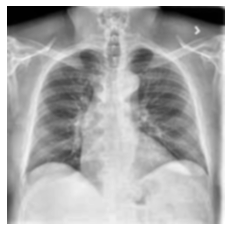

In [ ]:
img, label = sampler.next()
tf.argmax(label, axis=-1).numpy()[0]
preprocess_img = preprocess(img)

img = np.squeeze(img)
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.grid()
plt.show()

Preprocessed image

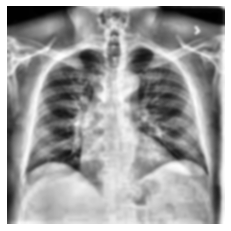

In [ ]:
preprocess_img = np.squeeze(preprocess_img)
plt.imshow(preprocess_img,cmap='gray')
plt.axis('off')
plt.grid()
plt.show()

#VGG19


##Transfer Learning

In [ ]:
# Download and plot the VGG19 model
supernet3 = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)

In [ ]:
for layer in supernet3.layers:
    layer.trainable = False

In [ ]:
from keras.layers import *
from keras import backend as K
class Gray2VGGInput( Layer ) :
    """Custom conversion layer
    """
    def build( self, x ) :
        self.image_mean = K.variable(value=np.array([103.939, 116.779, 123.68]).reshape([1,1,1,3]).astype('float32'), 
                                     dtype='float32', 
                                     name='imageNet_mean' )
        self.built = True
        return
    def call( self, x ) :
        rgb_x = K.concatenate( [x,x,x], axis=-1 )
        norm_x = rgb_x - self.image_mean
        return norm_x
    def compute_output_shape( self, input_shape ) :
        return input_shape[:3] + (3,)

In [ ]:
def build_model(input_shape, supernet):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    vgg_input = Gray2VGGInput( name='gray_to_rgb_norm')(input_layer)

    vgg19_layer = supernet(vgg_input) 

    flattening_layer = tfkl.Flatten(name='Flatten')(vgg19_layer)

    classifier_layer = tfkl.Dense(units=128, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout2 = tfkl.Dropout(0.5, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Build model and visualize it
vgg19 = build_model(input_shape, supernet3)
vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 1)]     0         
                                                                 
 gray_to_rgb_norm (Gray2VGGI  (None, 256, 256, 3)      3         
 nput)                                                           
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 Flatten (Flatten)           (None, 32768)             0         
                                                                 
 Classifier (Dense)          (None, 128)               4194432   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

In [ ]:
callbacks, model_folder_dir = create_folders_and_callbacks(dir=dir, model_name='vgg19')
    
# Prepare the data batches.
train_batches, valid_batches = prepare_batches(
    TRAINING_DATA_DIR, VALID_DATA_DIR, IMAGE_SHAPE, BATCH_SIZE
)

# TRAINING PHASE
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor="val_accuracy", restore_best_weights=True)
    
history = vgg19.fit(
    train_batches,
    epochs=100,
    validation_data=valid_batches,
    verbose=1,
    workers=4,
    use_multiprocessing=True,
    callbacks=callbacks,
    class_weight=weights,
    steps_per_epoch=STEPS_PER_EPOCH
)

/content/drive/MyDrive/Biomedicine/trained_models
/content/drive/MyDrive/Biomedicine/trained_models/vgg19_01-04_16-03-10
Epoch 1/100
78/78 [==============================] - 236s 2s/step - loss: 1.5806 - accuracy: 0.6468 - val_loss: 0.5531 - val_accuracy: 0.8022
Epoch 2/100
78/78 [==============================] - 184s 2s/step - loss: 0.8353 - accuracy: 0.7421 - val_loss: 0.4426 - val_accuracy: 0.8559
Epoch 3/100
78/78 [==============================] - 184s 2s/step - loss: 0.7989 - accuracy: 0.7695 - val_loss: 0.3951 - val_accuracy: 0.8546
Epoch 4/100
78/78 [==============================] - 187s 2s/step - loss: 0.7427 - accuracy: 0.7860 - val_loss: 0.4187 - val_accuracy: 0.8474
Epoch 5/100
78/78 [==============================] - 187s 2s/step - loss: 0.7389 - accuracy: 0.7887 - val_loss: 0.3275 - val_accuracy: 0.8901
Epoch 6/100
78/78 [==============================] - 179s 2s/step - loss: 0.7535 - accuracy: 0.7948 - val_loss: 0.2924 - val_accuracy: 0.9011
Epoch 7/100
78/78 [========

In [ ]:
if not os.path.exists(f'{dir}/vgg19_model/'):
    os.mkdir(f'{dir}/vgg19_model/')
vgg19.save(f'{dir}/vgg19_model/vgg19.h5')

In [ ]:
vgg19.save('saved_models/vgg16_60epochs')

In [ ]:
import keras
vgg19 = keras.models.load_model(f'{dir}/vgg19_model/vgg19.h5', custom_objects={"Gray2VGGInput": Gray2VGGInput})

In [ ]:
vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 1)]     0         
                                                                 
 gray_to_rgb_norm (Gray2VGGI  (None, 256, 256, 3)      3         
 nput)                                                           
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 Flatten (Flatten)           (None, 32768)             0         
                                                                 
 Classifier (Dense)          (None, 128)               4194432   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

0.9295410513877869 0.8728966116905212


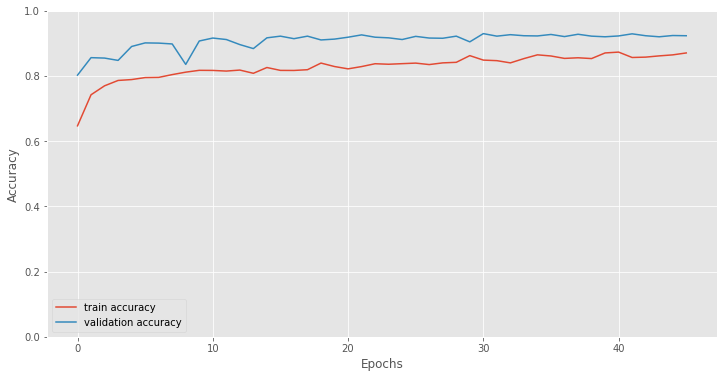

In [ ]:
plot_accuracy(history)

###evaluate on validation set

In [ ]:
vgg19.evaluate(valid_batches)

13/13 [==============================] - 16s 1s/step - loss: 0.2145 - accuracy: 0.9295


[0.21451811492443085, 0.9295410513877869]

In [ ]:
confusion_matrix_df = build_heatmap(vgg19, valid_batches)
report = compute_report(vgg19, valid_batches)

13/13 [==============================] - 15s 1s/step


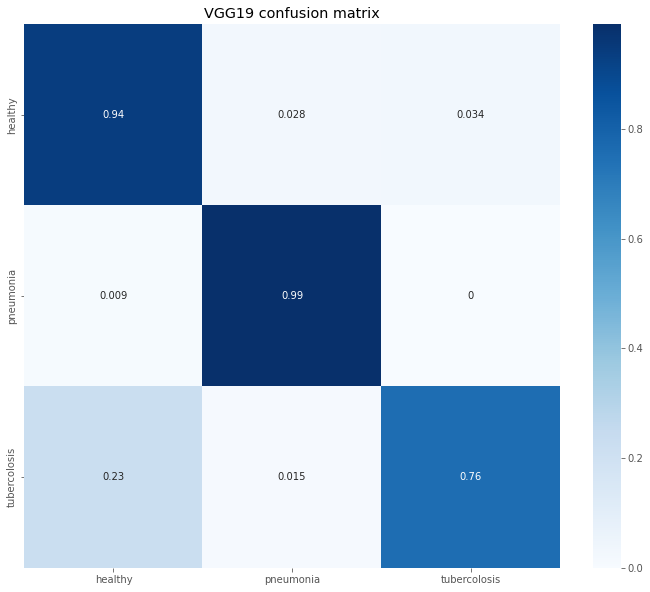

In [ ]:
labels = ['healthy', 'pneumonia', 'tubercolosis']

plt.figure(figsize=(12, 10))
plt.title('VGG19 confusion matrix')
sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues', yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
report

,n,p,t
precision,0.946272,0.936264,0.827778
recall,0.938043,0.990698,0.756345
f1-score,0.942140,0.962712,0.790451
support,920.000000,430.000000,197.000000


13/13 [==============================] - 14s 1s/step


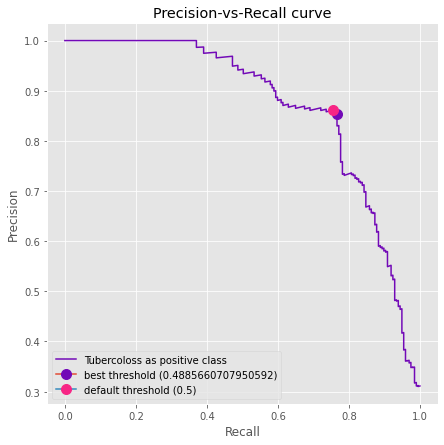

0.48856607

In [ ]:
y_true = np.concatenate([y for x, y in valid_batches], axis=0)
predictions = vgg19.predict(valid_batches) 
plot_precision_recall_t(y_true, predictions)

[]

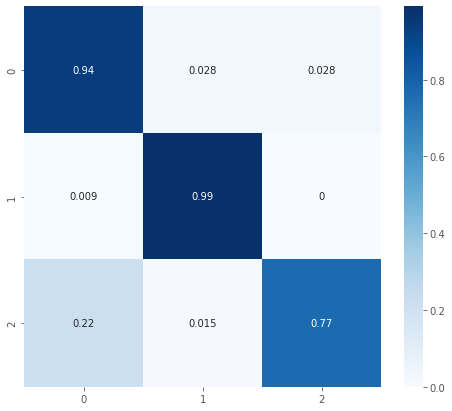

In [ ]:
plt.figure(figsize=(8, 7))
df = build_heatmap_custom(y_true, predictions, 0.48856607, policy=label_policy)
sns.heatmap(df, annot=True, cmap="Blues")
plt.plot()

In [ ]:
compute_report_custom(y_true, predictions, 0.48856607, policy=label_policy)

,n,p,t
precision,0.948634,0.936264,0.853107
recall,0.943478,0.990698,0.766497
f1-score,0.946049,0.962712,0.807487
support,920.000000,430.000000,197.000000


###evaluate on test set

In [ ]:
test = get_test_dataset(TEST_DATA_DIR, IMAGE_SHAPE, BATCH_SIZE)

In [ ]:
confusion_matrix_df = build_heatmap(vgg19, test)
report = compute_report(vgg19, test)

13/13 [==============================] - 13s 986ms/step


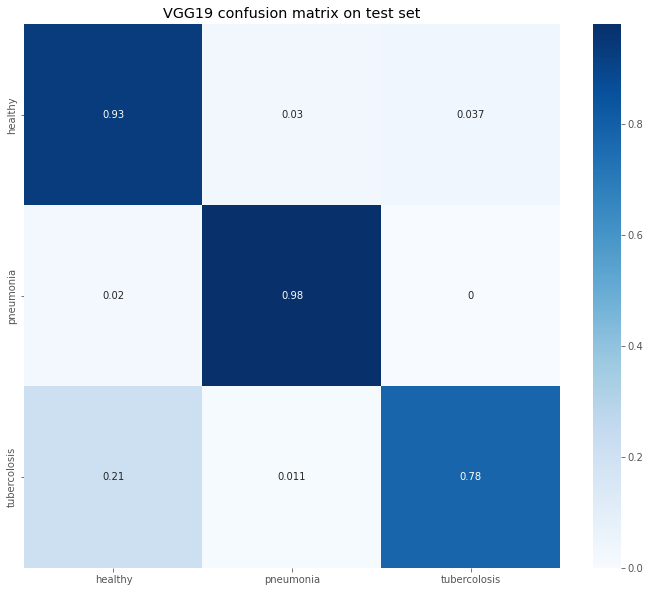

In [ ]:
labels = ['healthy', 'pneumonia', 'tubercolosis']

plt.figure(figsize=(12, 10))
plt.title('VGG19 confusion matrix on test set')
sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues', yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
report

,n,p,t
precision,0.949840,0.928074,0.805556
recall,0.932914,0.980392,0.779570
f1-score,0.941301,0.953516,0.792350
support,954.000000,408.000000,186.000000


###Gradcam 

In [ ]:
_, validation = prepare_batches(
    TRAINING_DATA_DIR, VALID_DATA_DIR, IMAGE_SHAPE, 1
)

sampler = validation.shuffle(2000)
sampler = iter(sampler)

In [ ]:
img, label = sampler.next()
tf.argmax(label, axis=-1).numpy()[0]

1

In [ ]:
def display_gradcam(model, img, last_convolution_name):
    name_last_conv = last_convolution_name

    heatmap = make_gradcam_heatmap(img, model, name_last_conv)
    interpreted_prediction = gradcam(img[0], heatmap, alpha=0.5)


    cmap = plt.get_cmap('jet')
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    plt.figure(figsize=(6, 6))
    plt.title('Diagnosis explainability')
    plt.imshow(interpreted_prediction)
    plt.colorbar(sm, ticks=[0, 1])
    plt.grid()
    plt.axis('off')
    plt.show()

In [ ]:
def build_sequence(input_shape, supernet):

    # Build the neural network layer by layer
    base_model = tfk.applications.VGG19(weights='imagenet', input_shape=input_shape, include_top=False)

    # Add a custom layer on top of the base model to make predictions
    x = base_model.output

    flattening_layer = tfkl.Flatten(name='Flatten')(x)

    classifier_layer = tfkl.Dense(units=128, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout2 = tfkl.Dropout(0.5, seed=seed, name='dropout')(classifier_layer)

    output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=base_model.input, outputs=output_layer, name='model')

    # Freeze the base model so that it is not updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Build model with all vgg19 layers and visualize it
input_s=(256,256,3)
vgg19_unrolled = build_sequence(input_s, supernet3)
vgg19_unrolled.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
for layer in vgg19.layers[2:]:
  print(layer.name)
  if layer.name != 'vgg19':
    weight = layer.get_weights()
    vgg19_unrolled.get_layer(layer.name).set_weights(weight)
  else:
    for inner_layer in layer.layers[1:]: 
      #inner layers in 'vgg19' layer
      weight = inner_layer.get_weights()
      vgg19_unrolled.get_layer(inner_layer.name).set_weights(weight)

In [ ]:
tf.argmax(vgg19_unrolled.predict(img), axis=-1).numpy()[0]

1/1 [==============================] - 3s 3s/step


1

In [ ]:
vgg19.get_layer('vgg19').get_layer('block5_conv4')

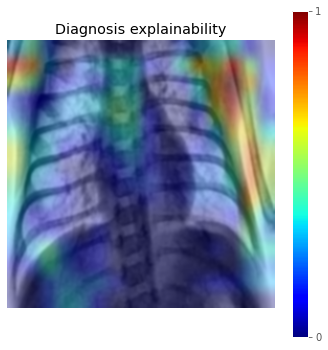

In [ ]:
display_gradcam(vgg19_unrolled, img, 'block5_conv4')

##Fine Tuning

In [ ]:
import keras
vgg19 = keras.models.load_model(f'{dir}/vgg19_model/vgg19.h5', custom_objects={"Gray2VGGInput": Gray2VGGInput})

In [ ]:
#unfreeze last 10 layers
for layer in vgg19.get_layer('vgg19').layers[-10:]:
  layer.trainable = True

In [ ]:
#compile the model with a lower learning rate
vgg19.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
callbacks, model_folder_dir = create_folders_and_callbacks(dir=dir, model_name='vgg19')
    
# Prepare the data batches.
train_batches, valid_batches = prepare_batches(
    TRAINING_DATA_DIR, VALID_DATA_DIR, IMAGE_SHAPE, BATCH_SIZE
)

# TRAINING PHASE
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor="val_accuracy", restore_best_weights=True)
    
history = vgg19.fit(
    train_batches,
    epochs=100,
    validation_data=valid_batches,
    verbose=1,
    workers=4,
    use_multiprocessing=True,
    callbacks=callbacks,
    class_weight=weights,
    steps_per_epoch=STEPS_PER_EPOCH
)

/content/drive/MyDrive/Biomedicine/trained_models
/content/drive/MyDrive/Biomedicine/trained_models/vgg19_01-05_18-39-37
Epoch 1/100
78/78 [==============================] - 248s 3s/step - loss: 0.4142 - accuracy: 0.9252 - val_loss: 0.1770 - val_accuracy: 0.9431
Epoch 2/100
78/78 [==============================] - 204s 3s/step - loss: 0.4819 - accuracy: 0.9139 - val_loss: 0.1420 - val_accuracy: 0.9541
Epoch 3/100
78/78 [==============================] - 202s 3s/step - loss: 0.4962 - accuracy: 0.9160 - val_loss: 0.1476 - val_accuracy: 0.9502
Epoch 4/100
78/78 [==============================] - 197s 3s/step - loss: 0.4749 - accuracy: 0.9148 - val_loss: 0.1602 - val_accuracy: 0.9470
Epoch 5/100
78/78 [==============================] - 200s 3s/step - loss: 0.4849 - accuracy: 0.9150 - val_loss: 0.1523 - val_accuracy: 0.9560
Epoch 6/100
78/78 [==============================] - 196s 3s/step - loss: 0.5144 - accuracy: 0.9120 - val_loss: 0.1386 - val_accuracy: 0.9593
Epoch 7/100
78/78 [========

In [ ]:
if not os.path.exists(f'{dir}/vgg19_model/'):
    os.mkdir(f'{dir}/vgg19_model/')
vgg19.save(f'{dir}/vgg19_model/vgg19_ft_1.h5')

0.959276020526886 0.9268830418586731


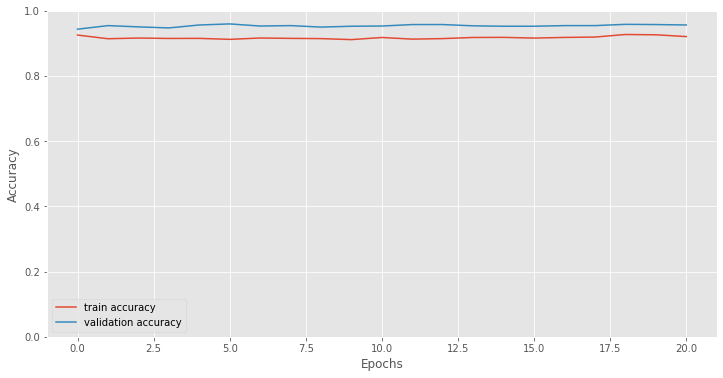

In [ ]:
plot_accuracy(history)

###evaluate on val set

In [ ]:
vgg19.evaluate(valid_batches)

13/13 [==============================] - 16s 1s/step - loss: 0.1386 - accuracy: 0.9593


[0.13864943385124207, 0.959276020526886]

In [ ]:
confusion_matrix_df = build_heatmap(vgg19, valid_batches)
report = compute_report(vgg19, valid_batches)

13/13 [==============================] - 16s 1s/step


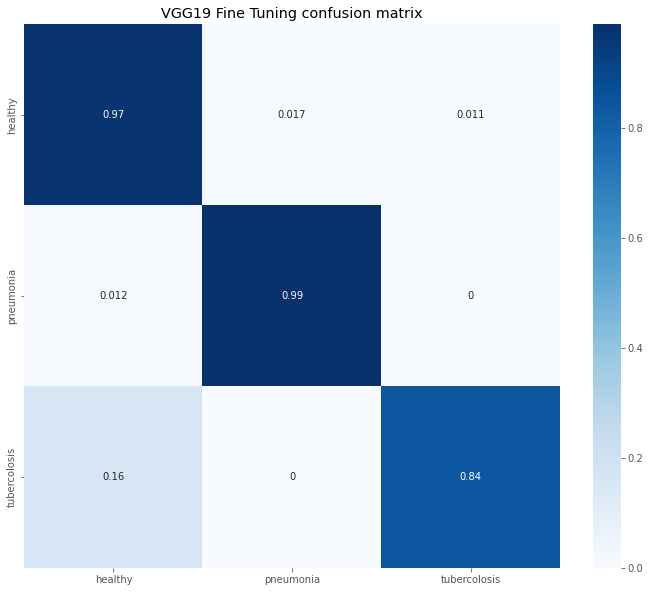

In [ ]:
labels = ['healthy', 'pneumonia', 'tubercolosis']

plt.figure(figsize=(12, 10))
plt.title('VGG19 Fine Tuning confusion matrix')
sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues', yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
report

,n,p,t
precision,0.960258,0.963719,0.942857
recall,0.971739,0.988372,0.837563
f1-score,0.965964,0.975890,0.887097
support,920.000000,430.000000,197.000000


13/13 [==============================] - 14s 1s/step


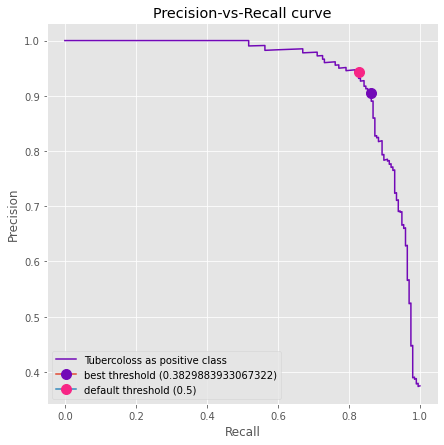

0.3829884

In [ ]:
y_true = np.concatenate([y for x, y in valid_batches], axis=0)
predictions = vgg19.predict(valid_batches) 
plot_precision_recall_t(y_true, predictions)

[]

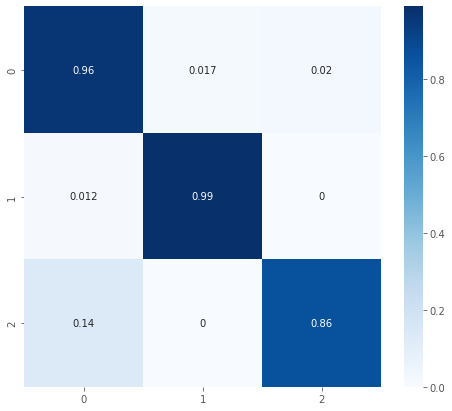

In [ ]:
plt.figure(figsize=(8, 7))
df = build_heatmap_custom(y_true, predictions, 0.3829884, policy=label_policy)
sns.heatmap(df, annot=True, cmap="Blues")
plt.plot()

In [ ]:
compute_report_custom(y_true, predictions, 0.3829884, policy=label_policy)

,n,p,t
precision,0.965142,0.963719,0.904255
recall,0.963043,0.988372,0.862944
f1-score,0.964091,0.975890,0.883117
support,920.000000,430.000000,197.000000


###evaluate on test set

In [ ]:
confusion_matrix_df = build_heatmap(vgg19, test)
report = compute_report(vgg19, test)

13/13 [==============================] - 13s 959ms/step


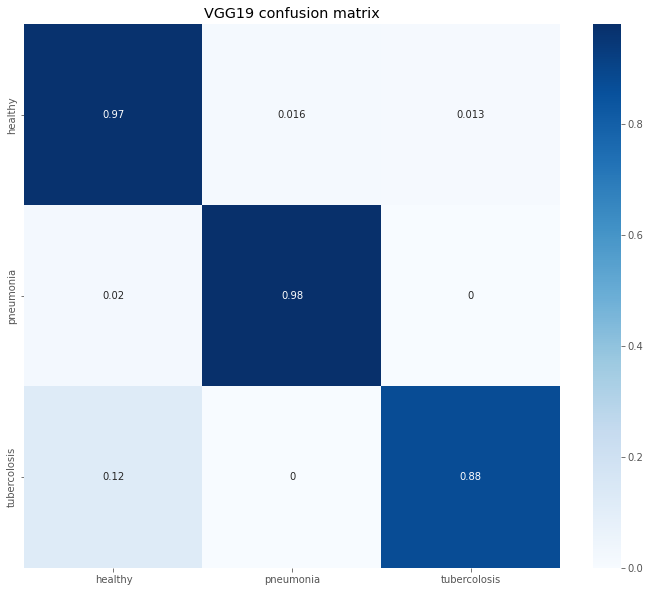

In [ ]:
labels = ['healthy', 'pneumonia', 'tubercolosis']

plt.figure(figsize=(12, 10))
plt.title('VGG19 confusion matrix')
sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues', yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
report

,n,p,t
precision,0.967641,0.963855,0.931429
recall,0.971698,0.980392,0.876344
f1-score,0.969665,0.972053,0.903047
support,954.000000,408.000000,186.000000


###Gradcam

In [ ]:
_, validation = prepare_batches(
    TRAINING_DATA_DIR, VALID_DATA_DIR, IMAGE_SHAPE, 1
)

sampler = validation.shuffle(2000)
sampler = iter(sampler)

In [ ]:
img, label = sampler.next()
tf.argmax(label, axis=-1).numpy()[0]

1

In [ ]:
def build_sequence2(input_shape, supernet):

    #model = tfk.Sequential(name= 'model')

    # Build the neural network layer by layer
    base_model = tfk.applications.VGG19(weights='imagenet', input_shape=input_shape, include_top=False)

    # Add a custom layer on top of the base model to make predictions
    x = base_model.output

    flattening_layer = tfkl.Flatten(name='Flatten')(x)

    classifier_layer = tfkl.Dense(units=128, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout2 = tfkl.Dropout(0.5, seed=seed, name='dropout')(classifier_layer)

    output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=base_model.input, outputs=output_layer, name='model')

    # Freeze the base model so that it is not updated during training
    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Build model and visualize it
input_s=(256,256,3)
vgg19_unrolled = build_sequence2(input_s, supernet3)
vgg19_unrolled.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
for layer in vgg19.layers[2:]:
  print(layer.name)
  if layer.name != 'vgg19':
    weight = layer.get_weights()
    vgg19_unrolled.get_layer(layer.name).set_weights(weight)
  else:
    for inner_layer in layer.layers[1:]: 
      #inner layers in 'vgg19' layer
      weight = inner_layer.get_weights()
      vgg19_unrolled.get_layer(inner_layer.name).set_weights(weight)

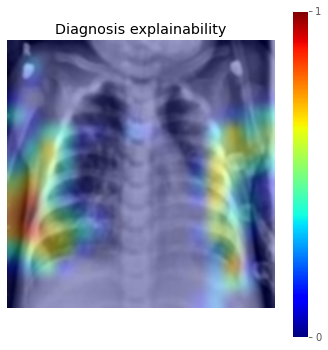

In [ ]:
display_gradcam(vgg19_unrolled, img, 'block5_conv4')

##Fine Tuning 2


In [ ]:
import keras
vgg19 = keras.models.load_model(f'{dir}/vgg19_model/vgg19_ft_1.h5', custom_objects={"Gray2VGGInput": Gray2VGGInput})

In [ ]:
#unfreeze all the layers
for layer in vgg19.get_layer('vgg19').layers:
  layer.trainable = True

In [ ]:
vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 1)]     0         
                                                                 
 gray_to_rgb_norm (Gray2VGGI  (None, 256, 256, 3)      3         
 nput)                                                           
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 Flatten (Flatten)           (None, 32768)             0         
                                                                 
 Classifier (Dense)          (None, 128)               4194432   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

In [ ]:
#reduce again the learning rate
vgg19.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-6), metrics='accuracy')

In [ ]:
callbacks, model_folder_dir = create_folders_and_callbacks(dir=dir, model_name='vgg19')
    
# Prepare the data batches.
train_batches, valid_batches = prepare_batches(
    TRAINING_DATA_DIR, VALID_DATA_DIR, IMAGE_SHAPE, BATCH_SIZE
)

# TRAINING PHASE
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor="val_accuracy", restore_best_weights=True)
    
history = vgg19.fit(
    train_batches,
    epochs=100,
    validation_data=valid_batches,
    verbose=1,
    workers=4,
    use_multiprocessing=True,
    callbacks=callbacks,
    class_weight=weights,
    steps_per_epoch=STEPS_PER_EPOCH
)

/content/drive/MyDrive/Biomedicine/trained_models
/content/drive/MyDrive/Biomedicine/trained_models/vgg19_01-06_09-44-32
Epoch 1/100
78/78 [==============================] - 359s 4s/step - loss: 0.4023 - accuracy: 0.9314 - val_loss: 0.1516 - val_accuracy: 0.9541
Epoch 2/100
78/78 [==============================] - 290s 4s/step - loss: 0.4760 - accuracy: 0.9202 - val_loss: 0.1398 - val_accuracy: 0.9586
Epoch 3/100
78/78 [==============================] - 293s 4s/step - loss: 0.4909 - accuracy: 0.9175 - val_loss: 0.1392 - val_accuracy: 0.9599
Epoch 4/100
78/78 [==============================] - 290s 4s/step - loss: 0.4609 - accuracy: 0.9267 - val_loss: 0.1379 - val_accuracy: 0.9606
Epoch 5/100
78/78 [==============================] - 285s 4s/step - loss: 0.4773 - accuracy: 0.9201 - val_loss: 0.1438 - val_accuracy: 0.9586
Epoch 6/100
78/78 [==============================] - 286s 4s/step - loss: 0.4946 - accuracy: 0.9213 - val_loss: 0.1462 - val_accuracy: 0.9567
Epoch 7/100
78/78 [========

In [ ]:
if not os.path.exists(f'{dir}/vgg19_model/'):
    os.mkdir(f'{dir}/vgg19_model/')
vgg19.save(f'{dir}/vgg19_model/vgg19_ft_2.h5')

0.9605688452720642 0.9313902258872986


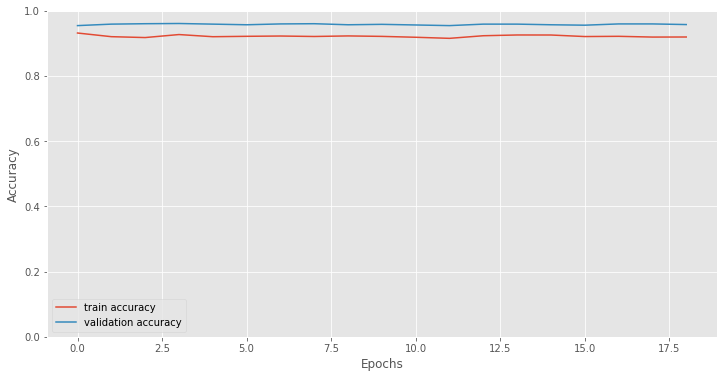

In [ ]:
plot_accuracy(history)

###evaluate on val set

In [ ]:
vgg19.evaluate(valid_batches)

13/13 [==============================] - 14s 1s/step - loss: 0.1379 - accuracy: 0.9606


[0.1378818303346634, 0.9605688452720642]

In [ ]:
confusion_matrix_df = build_heatmap(vgg19, valid_batches)
report = compute_report(vgg19, valid_batches)

13/13 [==============================] - 15s 1s/step


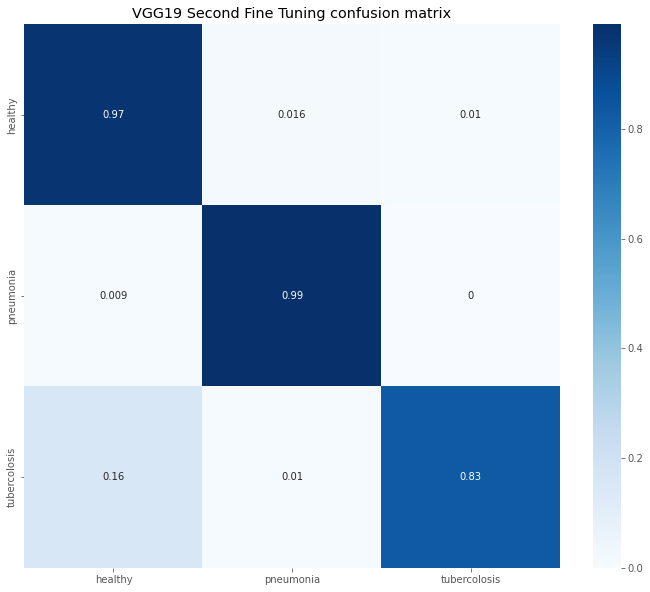

In [ ]:
labels = ['healthy', 'pneumonia', 'tubercolosis']

plt.figure(figsize=(12, 10))
plt.title('VGG19 Second Fine Tuning confusion matrix')
sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues', yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
report

,n,p,t
precision,0.962406,0.961625,0.947977
recall,0.973913,0.990698,0.832487
f1-score,0.968125,0.975945,0.886486
support,920.000000,430.000000,197.000000


13/13 [==============================] - 14s 1s/step


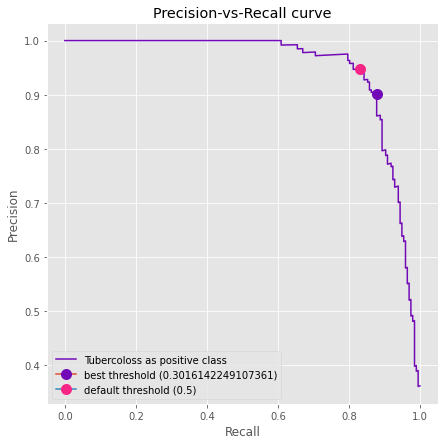

0.30161422

In [ ]:
y_true = np.concatenate([y for x, y in valid_batches], axis=0)
predictions = vgg19.predict(valid_batches) 
plot_precision_recall_t(y_true, predictions)

[]

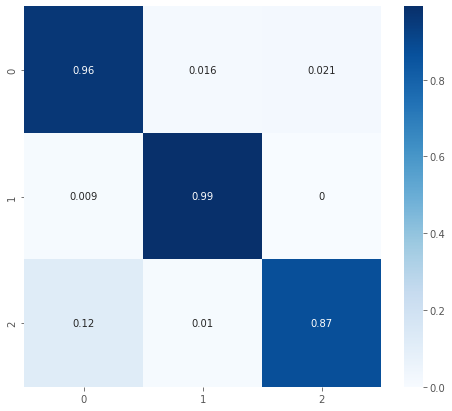

In [ ]:
plt.figure(figsize=(8, 7))
df = build_heatmap_custom(y_true, predictions, 0.30161422, policy=label_policy)
sns.heatmap(df, annot=True, cmap="Blues")
plt.plot()

In [ ]:
compute_report_custom(y_true, predictions, 0.30161422, policy=label_policy)

,n,p,t
precision,0.970427,0.961625,0.900524
recall,0.963043,0.990698,0.873096
f1-score,0.966721,0.975945,0.886598
support,920.000000,430.000000,197.000000


###evaluate on test set

In [ ]:
confusion_matrix_df = build_heatmap(vgg19, test)
report = compute_report(vgg19, test)

13/13 [==============================] - 13s 966ms/step


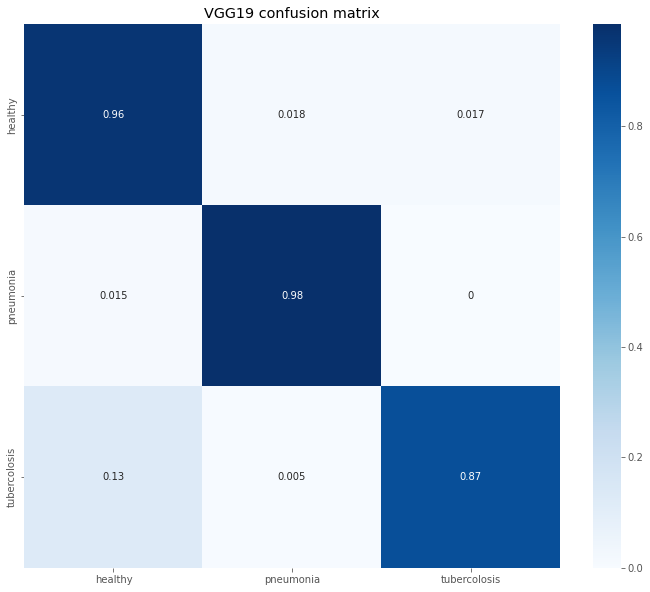

In [ ]:
labels = ['healthy', 'pneumonia', 'tubercolosis']

plt.figure(figsize=(12, 10))
plt.title('VGG19 confusion matrix')
sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues', yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
report

,n,p,t
precision,0.968454,0.957143,0.909605
recall,0.965409,0.985294,0.865591
f1-score,0.966929,0.971014,0.887052
support,954.000000,408.000000,186.000000


###Gradcam

In [ ]:
_, validation = prepare_batches(
    TRAINING_DATA_DIR, VALID_DATA_DIR, IMAGE_SHAPE, 1
)

sampler = validation.shuffle(2000)
sampler = iter(sampler)

In [ ]:
img, label = sampler.next()
tf.argmax(label, axis=-1).numpy()[0]

In [ ]:
def build_sequence3(input_shape, supernet):

    #model = tfk.Sequential(name= 'model')

    # Build the neural network layer by layer
    base_model = tfk.applications.VGG19(weights='imagenet', input_shape=input_shape, include_top=False)

    # Add a custom layer on top of the base model to make predictions
    x = base_model.output

    flattening_layer = tfkl.Flatten(name='Flatten')(x)

    classifier_layer = tfkl.Dense(units=128, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout2 = tfkl.Dropout(0.5, seed=seed, name='dropout')(classifier_layer)

    output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=base_model.input, outputs=output_layer, name='model')

    # Unfreeze the base model 
    for layer in base_model.layers:
        layer.trainable = True

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Build model and visualize it
input_s=(256,256,3)
vgg19_unrolled = build_sequence3(input_s, supernet3)
vgg19_unrolled.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
for layer in vgg19.layers[2:]:
  print(layer.name)
  if layer.name != 'vgg19':
    weight = layer.get_weights()
    vgg19_unrolled.get_layer(layer.name).set_weights(weight)
  else:
    for inner_layer in layer.layers[1:]: 
      #inner layers in 'vgg19' layer
      weight = inner_layer.get_weights()
      vgg19_unrolled.get_layer(inner_layer.name).set_weights(weight)

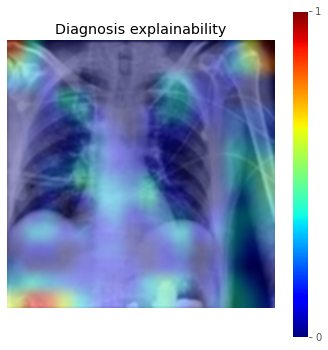

In [ ]:
display_gradcam(vgg19_unrolled, img, 'block5_conv4')